# Import Packages

In [1]:
from collections import Counter

from matplotlib.cm import get_cmap
import pandas as pd
import plotly.express as px

from pymodulon.core import IcaData
from pymodulon.plotting import *
from pymodulon.io import load_json_model, save_to_json

In [2]:
pd.set_option('display.max_rows', 300)

# Load IcaData object

In [3]:
ica_data = load_json_model('../data/precise2/precise2.json.gz')

In [6]:
imod_table = ica_data.imodulon_table

In [33]:
imod_total_var = explained_variance(ica_data)

# Category Breakdowns

In [68]:
def bar_and_pie(category, title, figsize=(20, 5)):
    imod_cat_counts = Counter(imod_table[category])
    sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
    
    if len(sorted_cats) < 10:
        color_dict = dict(zip(sorted_cats, get_cmap('tab10').colors))
    elif len(sorted_cats) < 20:
        color_dict = dict(zip(sorted_cats, get_cmap('tab20').colors))
    elif len(sorted_cats) < 40:
        color_dict = dict(zip(sorted_cats, get_cmap('tab20b').colors + get_cmap('tab20c').colors))
    # add a manual line for the unexplained variance category
    color_dict['Unexplained'] = 'gray'
    
    _, (ax_bar, ax_pie, ax_pie_var) = plt.subplots(1, 3, figsize=figsize)

    bar_range = -1 * np.arange(0, len(sorted_cats))
    ax_bar.barh(bar_range, sorted_counts, tick_label=sorted_cats, color=[color_dict[cat] for cat in sorted_cats])
    ax_bar.set_xlabel('# of iModulons', fontsize=16)
    ax_bar.set_title(f'{title} (n={imod_table.shape[0]})', fontsize=16)
    ax_bar.tick_params(axis='both', labelsize=15)
    if len(sorted_counts) < 20:
        for height, count in zip(bar_range, sorted_counts):
            ax_bar.text(count+1, height, count, fontsize=15, va='center')
        ax_bar.set_xlim(right=sorted_counts[0] + 15)
    for i in ax_bar.spines.values():
        i.set_linewidth(2)

    pie_labels = []
    for cat, count in zip(sorted_cats, sorted_counts):
        if count/imod_table.shape[0] < 0.06 and len(sorted_cats) > 7:
            pie_labels.append('')
        else:
            pie_labels.append(f'{cat} ({count})')
    
    ax_pie.pie(sorted_counts, labels=pie_labels, colors=[color_dict[cat] for cat in sorted_cats],
              textprops={'fontsize': 14})
    ax_pie.set_title(f'{title} (n={imod_table.shape[0]})', fontsize=16)
    
    exp_vars = []
    exp_var_tot = imod_table['exp_var'].sum()
    # manually add in the "unexplained" category
    cats_var = list(sorted_cats) + ['Unexplained']
    for cat in cats_var:
        if cat == 'unexplained':
            exp_var = 100 - imod_total_var
        else:
            exp_var = imod_table[imod_table[category] == cat]['exp_var'].sum()
        exp_vars.append(exp_var)
    sorted_vars, sorted_cats_var = zip(*sorted(zip(exp_vars, cats_var), key=lambda tup: tup[0], reverse=True))
    
    pie_labels_var = []
    for cat, var in zip(sorted_cats_var, sorted_vars):
        if var < 5 and len(sorted_cats_var) > 7:
            pie_labels_var.append('')
        else:
            pie_labels_var.append(f'{cat} ({max(int(np.round(var, decimals=0)), 1)}%)')
    
    ax_pie_var.pie(sorted_vars, labels=pie_labels_var, colors=[color_dict[cat] for cat in sorted_cats_var],
              textprops={'fontsize': 14})
    ax_pie_var.set_title('Explained Variance Breakdown', fontsize=16)
    
    plt.tight_layout()

## iModulon Category

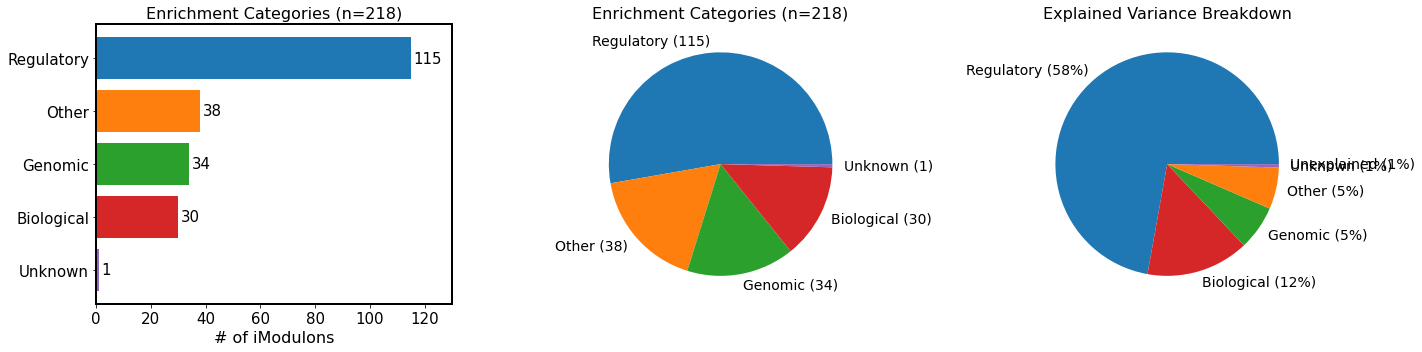

In [69]:
bar_and_pie('imodulon_category', 'Enrichment Categories')

## Functional Category

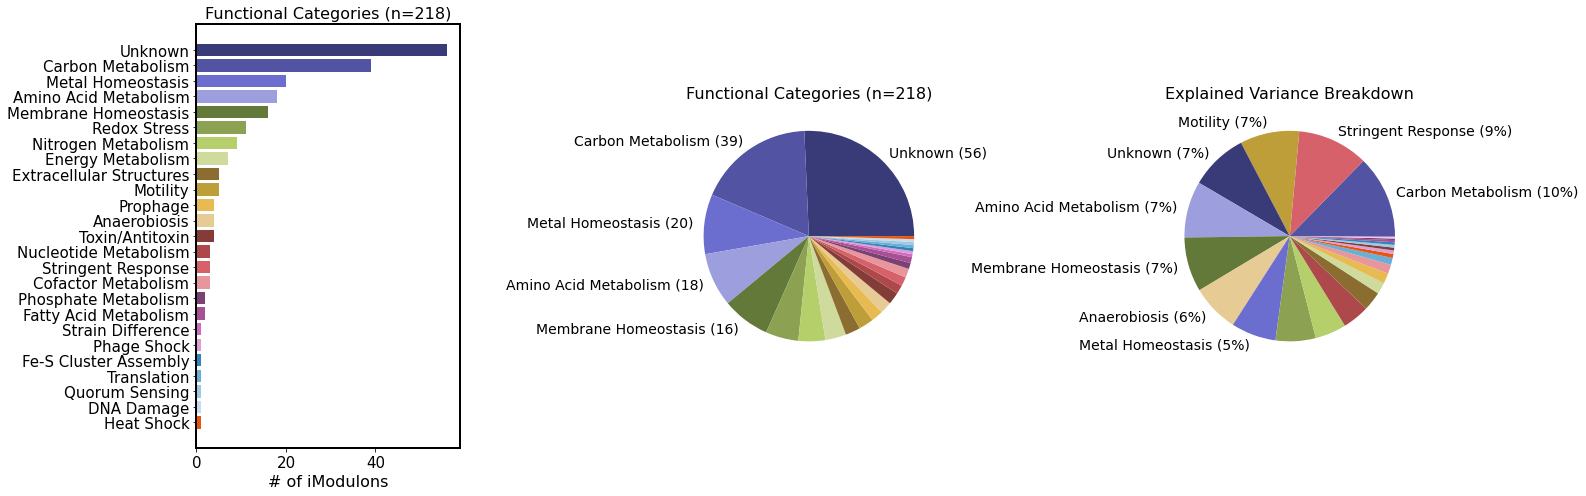

In [70]:
bar_and_pie('functional_category', 'Functional Categories', figsize=(22, 7))

## System Category

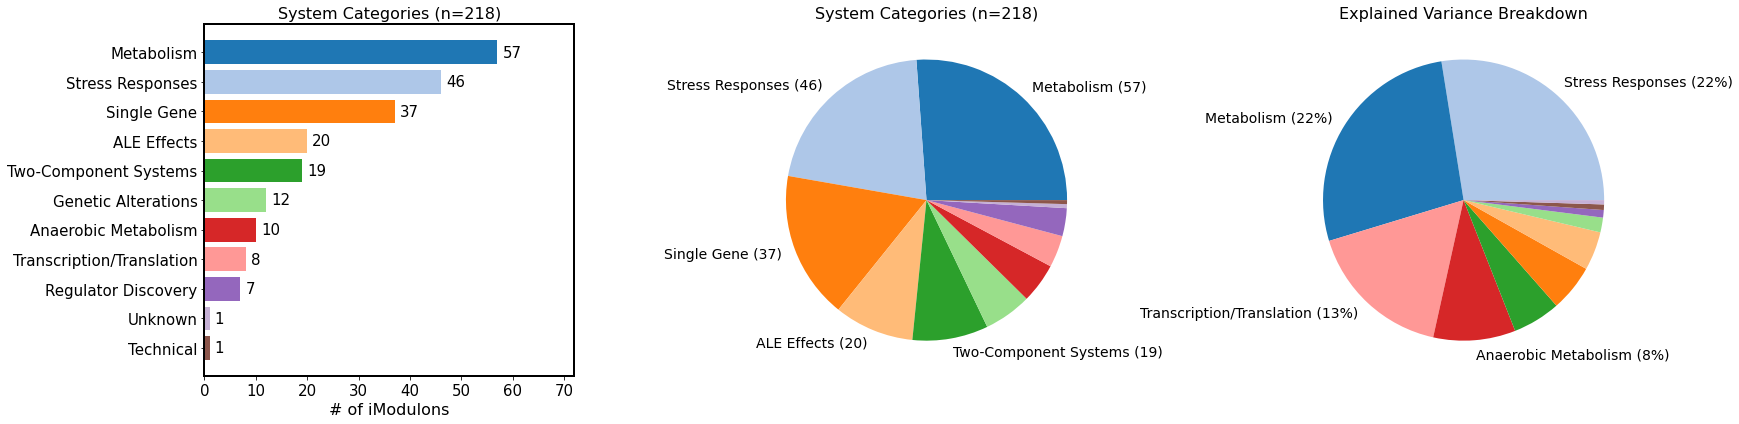

In [71]:
bar_and_pie('annotation_category', 'System Categories', figsize=(24, 6))

# Sunburst 

## By Count

In [ ]:
px.sunburst(imod_table, path=['imodulon_category', 'annotation_category', 'functional_category'],
           width=750, height=750, color='imodulon_category')

## By Explained Variance

In [ ]:
px.sunburst(imod_table, path=['imodulon_category', 'annotation_category', 'functional_category'], values='exp_var',
           width=750, height=750, color='imodulon_category')